# Bank Marketing Campaign Project

Data Set Information:

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

Attribute Information:

Input variables:
bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')
- contact: contact communication type (categorical: 'cellular','telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric).

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: 'yes','no')

This dataset is public available for research. The details are described in [Moro et al., 2014].

Please include this citation if you plan to use this database:

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [1]:
#IMPORT LIBRARIES
import pandas as pd
import pandas_profiling 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import time
import gc
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

In [2]:
#import the dataset
bank = pd.read_csv("../Data/bank-full.csv", sep=";")

In [3]:
#Making some copies just in case
bank_1 = bank.copy()
bank_2 = bank.copy()

# Exploring Data

In [4]:
#Exploring the dataset
bank.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
#Check for missing values
bank.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

There are no missing values in the dataset

In [6]:
#Further exploring the data
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


The variable "pdays" has a -1 value, I will change it to 0 which means 0 days have passde since last contact beacuse hat client has never been contacted before.

In [7]:
#Replace the value -1 for 0
bank.pdays = bank.pdays.replace(-1, 0)

There are some values in the dataset that I will change in order to make more sense of some variables.
For example, I know that unknown value in the contact feature is actually "telephone" by looking at the description of the dataset.

In [8]:
#Replace the value of unknown for telephone
bank["contact"].replace({"unknown": "telephone"}, inplace=True)

The values of "poutcome" are either succes, failure or unknown. So I will change the "other" value to unknown.

In [9]:
#Changing the value of other to unknown
bank["poutcome"].replace({"other": "unknown"}, inplace=True)

# Preprocessing features

Preparing the features for machine learning.

## Categorical Features

There are many features with yes or no, so I will binary encode them( 1's and 0's).
This features are: "contact", "loan", "housing", "defult" and "previous". 

In [10]:
#Replacing values with binary ()
bank.contact = bank.contact.map({'cellular': 1, 'telephone': 0})
bank.loan = bank.loan.map({'yes': 1, 'no' : 0})
bank.housing = bank.housing.map({'yes': 1, 'no' : 0})
bank.default = bank.default.map({'yes': 1, 'no': 0})
bank.previous = bank.previous.apply(lambda x: 1 if x > 0 else 0)

One Hot Encode the rest of the categorical features.
These are: 'job', 'marital', 'education', 'month', 'poutcome'

In [11]:
#Create a df with get_dummies(One hot encode) for certain columns
one = pd.get_dummies(data=bank, columns=['job', 'marital', 'education', 'month', 'poutcome'])

In [12]:
#Drop the duplicated columns
one = one.drop(columns=['age', 'default', 'balance', 'housing', 'loan', 'contact', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'y'])

In [13]:
#Concatenate the one hoy encoded df with the original df
bank = pd.concat([bank, one], axis=1)

In [14]:
#Drop the duplicated columns from concatenating
bank = bank.drop(columns=['job', 'marital', 'education', 'month', 'poutcome'])

In [15]:
bank.shape

(45211, 46)

Now all my categorical features have been preprocessed and I ended up with 46 columns in my dataframe.

## Numerical Features

The duration column is in seconds and it varies a lot, to simplify, I will bin them or place them in categories I will create.

In [16]:
#Function for categorizing duration
def duration(data):
    data.loc[data['duration'] <= 120, 'duration'] = 1
    data.loc[(data['duration'] > 120) & (data['duration'] <= 240)  , 'duration'] = 2
    data.loc[(data['duration'] > 240) & (data['duration'] <= 360)  , 'duration'] = 3
    data.loc[(data['duration'] > 360) & (data['duration'] <= 600), 'duration'] = 4
    data.loc[data['duration']  > 600, 'duration'] = 5
    return data
duration(bank);

Same goes for the "age" column.

In [17]:
#Function for categorizing age
def age(data):
    data.loc[(data['age'] >= 18) & (data['age'] <= 25)  , 'age'] = 1
    data.loc[(data['age'] > 25) & (data['age'] <= 30)  , 'age'] = 2
    data.loc[(data['age'] > 30) & (data['age'] <= 35)  , 'age'] = 3
    data.loc[(data['age'] > 35) & (data['age'] <= 40)  , 'age'] = 4
    data.loc[(data['age'] > 40) & (data['age'] <= 45), 'age'] = 5
    data.loc[(data['age'] > 45) & (data['age'] <= 50), 'age'] = 6
    data.loc[(data['age'] > 50) & (data['age'] <= 55)  , 'age'] = 7
    data.loc[(data['age'] > 55) & (data['age'] <= 60)  , 'age'] = 8
    data.loc[data['age']  > 60, 'age'] = 9
    return data
age(bank);

Now that my numerical features are ready I will scale them.

In [18]:
#Scaling the colums that are not binary
from sklearn.preprocessing import MinMaxScaler, StandardScaler

idx_numeric=[0, 2 ,6, 7, 8, 9]
scaler = StandardScaler()
bank[bank.columns[idx_numeric]] = scaler.fit_transform(bank[bank.columns[idx_numeric]])

In [19]:
#The dataset is now scaled
bank.head()

,age,default,balance,housing,loan,contact,day,duration,campaign,pdays,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_success,poutcome_unknown
0,1.699584,0,0.256419,1,0,0,-1.298476,0.518057,-0.569351,-0.411009,...,0,0,0,1,0,0,0,0,0,1
1,0.220301,0,-0.437895,1,0,0,-1.298476,-0.273383,-0.569351,-0.411009,...,0,0,0,1,0,0,0,0,0,1
2,-0.765888,0,-0.446762,1,1,0,-1.298476,-1.064823,-0.569351,-0.411009,...,0,0,0,1,0,0,0,0,0,1
3,0.713395,0,0.047205,1,0,0,-1.298476,-1.064823,-0.569351,-0.411009,...,0,0,0,1,0,0,0,0,0,1
4,-0.765888,0,-0.447091,0,0,0,-1.298476,-0.273383,-0.569351,-0.411009,...,0,0,0,1,0,0,0,0,0,1


Plotting to see the distribution now that it has been scaled.

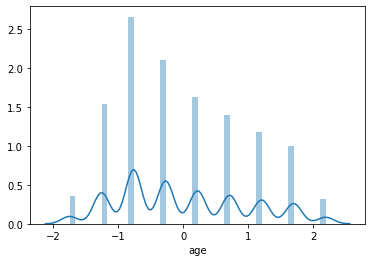

In [20]:
sns.distplot(bank['age'])

Encode the target variable with binary for the model.

In [21]:
#Encode target variable
bank['y'] = bank['y'].map({'no':0, 'yes':1})

Now that feature preprocessing is done, I will proceed to define the target variable.
I will not use the day column as I dont think has an impact on the outcome. More on the visualization.

In [22]:
#Define the X and the y
X = bank.drop(columns= ['y', 'day'])
y= bank.y

I proceed to the Train Test Split for the modelling

In [23]:
#Coding the train test spit to use for modelling
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=8)

# training datasets to DataFrame again to manipulate them
X_train = pd.DataFrame(X_train, columns= X.columns)
X_test = pd.DataFrame(X_test, columns= X.columns)

In [67]:
y_test.shape

(9043,)

CHeck for the most important features

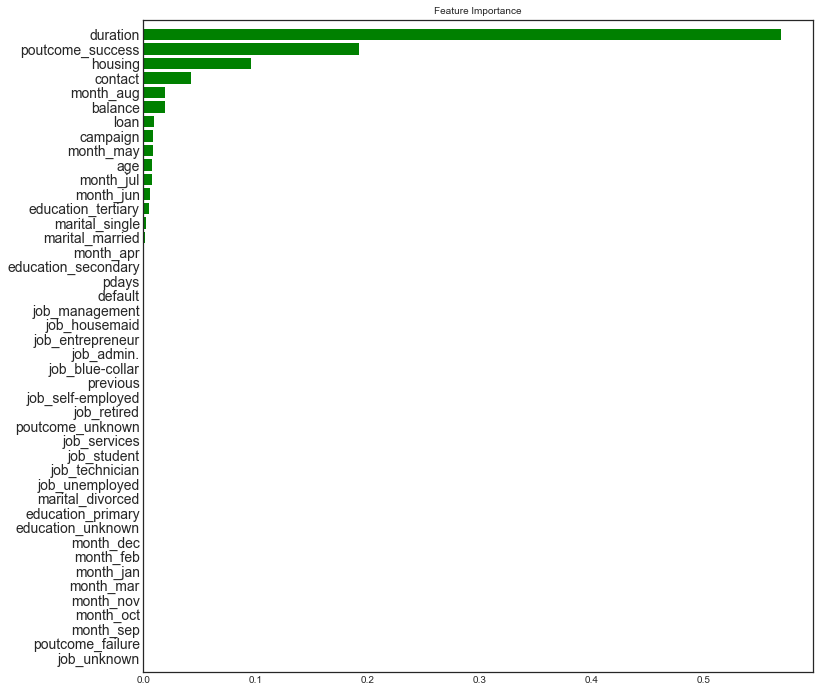

In [24]:
plt.style.use('seaborn-white')

clf = DecisionTreeClassifier(class_weight='balanced', min_weight_fraction_leaf = 0.01)

clf.fit(X_train, y_train)
importances = clf.feature_importances_
feature_names = X.columns
index = np.argsort(importances)

def feature_importance_graph(index, importances, feature_names):
    plt.figure(figsize=(12,12))
    plt.title("Feature Importance", fontsize=10)
    plt.barh(range(len(index)), importances[index], color='g',  align="center")
    plt.yticks(range(len(index)), feature_names[index], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(index)])
    
feature_importance_graph(index, importances, feature_names)
plt.show()

We can see that the most important feature are by far Duration poutcome and housing.

Our dataset is higly imbalanced. 88% said no to the term deposit, which is our target variable. Imbalanced classifications pose a challenge for predictive modeling as most of the machine learning algorithms used for classification were designed around the assumption of an equal number of examples for each class.

There are many techniques to tackle imbalanced data. In my case I will use the SMOTE(Synthetic Minority Oversampling Technique). SMOTE is one of the most commonly used oversampling methods to solve the imbalance problem. It aims to balance class distribution by randomly increasing minority class examples by replicating them. for more on SMOTE please refer to ####

# SMOTE

In [25]:
#import the package
from imblearn.over_sampling import SMOTE
from collections import Counter
#Set counterb
counter = Counter(y_train)
print(f'Before {counter}')
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print(f'After {counter}')

Before Counter({0: 31947, 1: 4221})
After Counter({1: 31947, 0: 31947})


We now have a perfectly balanced data. I shall proceed with the models.

# Modelling

I will use four classifiers: Logistic Regression, KN Nearest Neighbor, Decision Tree, Random Forest.

In [26]:
# dictionary to store accuracy and roc score for each model
result_acc = {}
result_auc = {}
model_dict = {0:'Logistic_reg', 1:'Knn', 2:'DesionTree', 3:'RandomForest'}

In [27]:
#Set random state
random_state = 42

#Set number of CPU's
n_jobs= -1

## Logistic Regression

In [28]:
# LogisticRegression
pipe_lr = Pipeline([('lr', LogisticRegression(random_state=random_state, n_jobs=n_jobs, max_iter=1000))])

In [29]:
#Fit the model and get the scores
start = time.time()
print()
        
print(f'Estimator is Logistic Regression')
pipe_lr.fit(X_train_sm, y_train_sm)
print(f'-'*30)
auc = roc_auc_score(y_test, pipe_lr.predict_proba(X_test)[:,1])
print(f'ROC_AUC is {auc}')
print(f'Accuracy rate is {pipe_lr.score(X_test, y_test)}')
print(f'-'*30)
end = time.time()
print(f'It took {round(end - start, 3)} seconds')
 


Estimator is Logistic Regression
------------------------------
ROC_AUC is 0.8843186220985525
Accuracy rate is 0.8666371779276789
------------------------------
It took 14.216 seconds


### Logistic Regression with Cross Validation

In [30]:
#Get the parameters for the model
from sklearn.base import BaseEstimator

print(pipe_lr.get_params())

{'memory': None, 'steps': [('lr', LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42))], 'verbose': False, 'lr': LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42), 'lr__C': 1.0, 'lr__class_weight': None, 'lr__dual': False, 'lr__fit_intercept': True, 'lr__intercept_scaling': 1, 'lr__l1_ratio': None, 'lr__max_iter': 1000, 'lr__multi_class': 'auto', 'lr__n_jobs': -1, 'lr__penalty': 'l2', 'lr__random_state': 42, 'lr__solver': 'lbfgs', 'lr__tol': 0.0001, 'lr__verbose': 0, 'lr__warm_start': False}


I am going to apply Logistic Regression Using Cross Validation

In [31]:
#Cross Validation
cv = StratifiedKFold(shuffle=True, random_state=random_state)

# set parameters for LogisticRegression
grid_lr = {'lr__C': [0.3, 0.5, 0.7],
        'lr__penalty': ['l2', 'l1'],
        'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
                

In [32]:
#Set the GridSearchCV with the grid of parameters
gs_lr = GridSearchCV(pipe_lr, param_grid= grid_lr,
                     scoring='accuracy', cv=cv) 

In [33]:
#Fit the model and get the scores

start = time.time()
print()
        
print(f'Estimator is Logistic Regression with Cross Validation')
gs_lr.fit(X_train_sm, y_train_sm)
print(f'-'*30)
print(f'Best params {gs_lr.best_params_}')
print(f'best score is {gs_lr.best_score_}')
auc = roc_auc_score(y_test, gs_lr.predict_proba(X_test)[:,1])
print(f'ROC_AUC is {auc}')
print(f'Accuracy rate is {gs_lr.score(X_test, y_test)}')
print(f'-'*30)
end = time.time()
print(f'It took {round(end - start, 3)} seconds')
result_acc["Logistic Regression"] = gs_lr.best_score_
log_auc = auc


Estimator is Logistic Regression with Cross Validation
------------------------------
Best params {'lr__C': 0.7, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
best score is 0.8915078775584029
ROC_AUC is 0.8836591408075329
Accuracy rate is 0.8681853367245383
------------------------------
It took 1233.337 seconds


## KN Nearest Neighbor

For KN Nearest Neighbor, for the n_neighbors I will use the square root of the amount of my sample. This is one of the rules of thumb when establishing the number of neighbors.

In [34]:
#Kn Nearest Neighbor using pipeline
pipe_knn = Pipeline([('knn', KNeighborsClassifier(n_neighbors=177, n_jobs=n_jobs))])

In [35]:
 #Fit the model and get the scores
start = time.time()
print()
        
print(f'Estimator is KNeighborsClassifier')
pipe_knn.fit(X_train_sm, y_train_sm)
print(f'-'*30)
auc = roc_auc_score(y_test, pipe_knn.predict_proba(X_test)[:,1])
print(f'ROC_AUC is {auc}')
print(f'Accuracy rate is {pipe_knn.score(X_test, y_test)}')
print(f'-'*30)
end = time.time()
print(f'It took {round(end - start, 3)} seconds')

       


Estimator is KNeighborsClassifier
------------------------------
ROC_AUC is 0.9023900766674886
Accuracy rate is 0.7645692801061594
------------------------------
It took 36.038 seconds


### KN Nearest Neighbor with cross validation

In [36]:
#Get the parameters for the model
from sklearn.base import BaseEstimator

print(pipe_knn.get_params())

{'memory': None, 'steps': [('knn', KNeighborsClassifier(n_jobs=-1, n_neighbors=177))], 'verbose': False, 'knn': KNeighborsClassifier(n_jobs=-1, n_neighbors=177), 'knn__algorithm': 'auto', 'knn__leaf_size': 30, 'knn__metric': 'minkowski', 'knn__metric_params': None, 'knn__n_jobs': -1, 'knn__n_neighbors': 177, 'knn__p': 2, 'knn__weights': 'uniform'}


In [37]:
#Set the parameters for cross validation
grid_knn = [{'knn__n_neighbors': [150, 177, 190],
                    'knn__metric': ['minkowski'],
                    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'knn__weights': ['uniform', 'distance']}]

In [38]:
#Set the GridSearchCV with the grid of parameters
gs_knn = GridSearchCV(pipe_knn, param_grid=grid_knn,
                     scoring='accuracy', cv=cv)

In [39]:
 #Fit the model and get the scores
start = time.time()
print()
        
print(f'Estimator is KNeighborsClassifier with GridSearchCV')
gs_knn.fit(X_train_sm, y_train_sm)
print(f'-'*30)
print(f'Best params {gs_knn.best_params_}')
print(f'best score is {gs_knn.best_score_}')
auc = roc_auc_score(y_test, gs_knn.predict_proba(X_test)[:,1])
print(f'ROC_AUC is {auc}')
print(f'Accuracy rate is {gs_knn.score(X_test, y_test)}')
print(f'-'*30)
end = time.time()
print(f'It took {round(end - start, 3)} seconds')
result_acc["KNeighbors"] = gs_knn.best_score_
kn_auc = auc


Estimator is KNeighborsClassifier with GridSearchCV
------------------------------
Best params {'knn__algorithm': 'auto', 'knn__metric': 'minkowski', 'knn__n_neighbors': 150, 'knn__weights': 'distance'}
best score is 0.8616302331981478
ROC_AUC is 0.9032752750284714
Accuracy rate is 0.7721994913192525
------------------------------
It took 2252.402 seconds


## Decision Trees

In [40]:
#Decision Tree using Pipeline
pipe_dt = Pipeline([('dt', DecisionTreeClassifier(random_state=random_state, max_features='auto'))])

In [41]:
 #Fit the model and get the scores
start = time.time()
print()
        
print(f'Estimator is Decision Trees Classifier')
pipe_dt.fit(X_train_sm, y_train_sm)
print(f'-'*30)
auc = roc_auc_score(y_test, pipe_dt.predict_proba(X_test)[:,1])
print(f'ROC_AUC is {auc}')
print(f'Accuracy rate is {pipe_dt.score(X_test, y_test)}')
print(f'-'*30)
end = time.time()
print(f'It took {round(end - start, 3)} seconds')


Estimator is Decision Trees Classifier
------------------------------
ROC_AUC is 0.7043368203538679
Accuracy rate is 0.8532566626119651
------------------------------
It took 0.173 seconds


### Decision Tree with Cross Validation

In [42]:
#Get the parameters for the model
from sklearn.base import BaseEstimator

print(pipe_dt.get_params())

{'memory': None, 'steps': [('dt', DecisionTreeClassifier(max_features='auto', random_state=42))], 'verbose': False, 'dt': DecisionTreeClassifier(max_features='auto', random_state=42), 'dt__ccp_alpha': 0.0, 'dt__class_weight': None, 'dt__criterion': 'gini', 'dt__max_depth': None, 'dt__max_features': 'auto', 'dt__max_leaf_nodes': None, 'dt__min_impurity_decrease': 0.0, 'dt__min_impurity_split': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2, 'dt__min_weight_fraction_leaf': 0.0, 'dt__random_state': 42, 'dt__splitter': 'best'}


In [43]:
#Set the parameters for cross validation
grid_dt = [{'dt__criterion': ['gini', 'entropy'],
            'dt__max_depth': [8, 10],
            'dt__min_samples_leaf': [1, 3, 5, 7]}]

In [44]:
#Set the GridSearchCV with the grid of parameters
gs_dt = GridSearchCV(pipe_dt, param_grid=grid_dt,
                     scoring='accuracy', cv=cv)

In [45]:
 #Fit the model and get the scores
start = time.time()
print()
        
print(f'Classifier is Decision Trees with GridSearchCV')
gs_dt.fit(X_train_sm, y_train_sm)
print(f'-'*30)
print(f'Best params {gs_dt.best_params_}')
print(f'best score is {gs_dt.best_score_}')
auc = roc_auc_score(y_test, gs_dt.predict_proba(X_test)[:,1])
print(f'ROC_AUC is {auc}')
print(f'Accuracy rate is {gs_dt.score(X_test, y_test)}')
print(f'-'*30)
end = time.time()
print(f'It took {round(end - start, 3)} seconds')
result_acc["Decision Tree"] = gs_dt.best_score_
dt_auc = auc


Classifier is Decision Trees with GridSearchCV
------------------------------
Best params {'dt__criterion': 'gini', 'dt__max_depth': 10, 'dt__min_samples_leaf': 5}
best score is 0.8476854212964902
ROC_AUC is 0.86635835299919
Accuracy rate is 0.8412031405507022
------------------------------
It took 7.062 seconds


## Random Forest

In [46]:
pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=random_state, n_jobs=n_jobs))])

In [47]:
#Fit the model and get the scores
start = time.time()
print()
        
print(f'Estimator is Random Forest Classifier')
pipe_rf.fit(X_train_sm, y_train_sm)
print(f'-'*30)
auc = roc_auc_score(y_test, pipe_rf.predict_proba(X_test)[:,1])
print(f'ROC_AUC is {auc}')
print(f'Accuracy rate is {pipe_rf.score(X_test, y_test)}')
print(f'-'*30)
end = time.time()
print(f'It took {round(end - start, 3)} seconds')

       


Estimator is Random Forest Classifier
------------------------------
ROC_AUC is 0.9085343947025466
Accuracy rate is 0.8875373216852814
------------------------------
It took 2.427 seconds


### Random Forest with Cross Validation

In [48]:
#Get the parameters for the model
from sklearn.base import BaseEstimator

print(pipe_rf.get_params())

{'memory': None, 'steps': [('rf', RandomForestClassifier(n_jobs=-1, random_state=42))], 'verbose': False, 'rf': RandomForestClassifier(n_jobs=-1, random_state=42), 'rf__bootstrap': True, 'rf__ccp_alpha': 0.0, 'rf__class_weight': None, 'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__max_leaf_nodes': None, 'rf__max_samples': None, 'rf__min_impurity_decrease': 0.0, 'rf__min_impurity_split': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__min_weight_fraction_leaf': 0.0, 'rf__n_estimators': 100, 'rf__n_jobs': -1, 'rf__oob_score': False, 'rf__random_state': 42, 'rf__verbose': 0, 'rf__warm_start': False}


In [49]:
#Set the parameters for cross validation
grid_rf = [{'rf__criterion': ['gini', 'entropy'],
            'rf__min_samples_leaf': [80, 100],
            'rf__max_depth': [15, 27],
            'rf__min_samples_split': [2, 5],
            'rf__n_estimators' : [50, 60, 70]}]

In [50]:
#Set the GridSearchCV with the grid of parameters
gs_rf = GridSearchCV(pipe_rf, param_grid=grid_rf,
                     scoring='accuracy', cv=cv)

In [51]:
#Fit the model and get the scores
start = time.time()
print()
        
print(f'Estimator is RandomForestClassifier with GridSearchCV')
gs_rf.fit(X_train_sm, y_train_sm)
print(f'-'*30)
print(f'Best params {gs_rf.best_params_}')
print(f'best score is {gs_rf.best_score_}')
auc = roc_auc_score(y_test, gs_rf.predict_proba(X_test)[:,1])
print(f'ROC_AUC is {auc}')
print(f'Accuracy rate is {gs_rf.score(X_test, y_test)}')
print(f'-'*30)
end = time.time()
print(f'It took {round(end - start, 3)} seconds')
result_acc['Random Forest'] = gs_rf.best_score_
rf_auc = auc


Estimator is RandomForestClassifier with GridSearchCV
------------------------------
Best params {'rf__criterion': 'entropy', 'rf__max_depth': 27, 'rf__min_samples_leaf': 80, 'rf__min_samples_split': 2, 'rf__n_estimators': 70}
best score is 0.8923686378415363
ROC_AUC is 0.9069633569323613
Accuracy rate is 0.854583655866416
------------------------------
It took 244.324 seconds


In [52]:
print(result_acc)

{'Logistic Regression': 0.8915078775584029, 'KNeighbors': 0.8616302331981478, 'Decision Tree': 0.8476854212964902, 'Random Forest': 0.8923686378415363}


In [64]:
results = {'Classifiers': ['Logistic Reg.','KNN', 'Dec Tree', 'Random Forest'], 
    'ROC_AUC Scores': [log_auc, kn_auc, dt_auc, rf_auc]}

In [65]:
table = pd.DataFrame(results)

In [66]:
table

,Classifiers,ROC_AUC Scores
0,Logistic Reg.,0.883659
1,KNN,0.903275
2,Dec Tree,0.866358
3,Random Forest,0.906963


The best Classifier is Random Forest.

Lets plot the the ROC Curve with the AUC scores for the random forest predictions

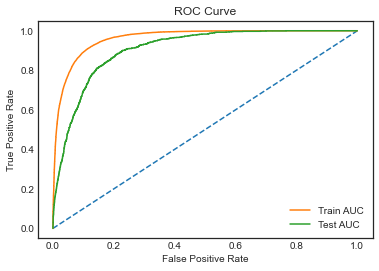

In [60]:
y_probs_train = gs_rf.predict_proba(X_train_sm)
y_probs_test = gs_rf.predict_proba(X_test)
y_predicted_train = gs_rf.predict(X_train_sm)
y_predicted_test = gs_rf.predict(X_test)


# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_test = y_probs_test[:, 1]


# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train_sm, y_probs_train)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_probs_test)
plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, label='Train AUC')
plt.plot(test_fpr, test_tpr, label='Test AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

Plot the Confusion Matrix for the train set

Confusion matrix:
 [[27833  4114]
 [ 2480 29467]]


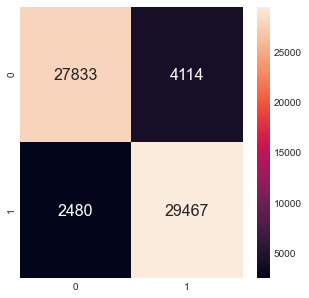

In [63]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_train_sm, y_predicted_train)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

PLot the confusion matrix for the test set

Confusion matrix:
 [[6878 1097]
 [ 218  850]]


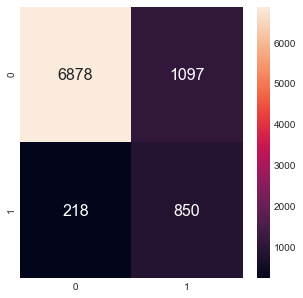

In [62]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_test, y_predicted_test)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')